# Relaxation Runge--Kutta

In [ ]:
# If you do not have numpy, matplotlib, scipy or nodepy, run this cell
!pip install numpy
# This is the basic package in python with all the numerical functions

!pip install scipy
# This package has some functions to deal with polynomials

!pip install matplotlib
# This package allows to  plot

!pip install nodepy
# This package has some interesting features for RK methods

In [1]:
# We need a couple of packages in this chapter
import numpy as np  
# This is the basic package in python with all the numerical functions

import matplotlib.pyplot as plt 
# This package allows to  plot

from nodepy import rk
#This package already implemented some functions for Runge Kutta and multistep methods

The relaxation technique is a modification of high order accurate time integration methods which allow to conserve or dissipate some quantities of interest, such as entropy or energy, that physically would be conserved or dissipated.

Consider again 

$$
y'=F(y)
$$

and suppose that we know that the kinetic energy is conserved (dissipated), i.e.

$$
\frac{d}{dt} \frac{1}{2} \langle y, y \rangle = \langle y, y' \rangle = \langle y, F(y) \rangle \stackrel{(\leq)}{=} 0.
$$

This is the case of many examples we have seen before, e.g. Dahlquist's equation with negative coefficient, nonlinear oscillator, damped nonlinear oscillator, semidiscretized conservation laws (linear transport equation, Burgers' equation).

More in general we might have a nonlinear quantity that is conserved (entropy, momentum, total energy (kinetic+potential))

$$
\frac{d}{dt}\eta(y)= \langle \partial_y \eta(y), y' \rangle = \langle \partial_y \eta(y), F(y) \rangle \stackrel{(\leq)}{=} 0.
$$

This is the case of nonlinear pendulum, Lotka-Volterra, other conservation laws (Euler's equation). 

Several relaxation methods have been proposed in the last 3 years: the relaxation Runge Kutta [Ketcheson 2019](https://arxiv.org/abs/1905.09847) (energy), [Ketcheson2020](https://arxiv.org/abs/1909.13215) (entropy)  and multistep methods [Ranocha 2020](https://arxiv.org/abs/2003.03012), all originally inspired by [Del Buono 2002](https://www.sciencedirect.com/science/article/pii/S0377042701003983?via%3Dihub).


Here, we present the version in case of kinetic energy for explicit RK methods 
$$
\begin{array}
{c|c}
c&A\\
\hline
& b^T
\end{array}
$$
where $A\in \mathbb R^{S\times S},\, b,c\in\mathbb R^S$, in the following formulation

$$
\begin{cases}
y^{(k)}=y^n + \Delta t \sum_{j=1}^S a_{kj} F(t^n+c_j\Delta t,y^{(j)}), \quad k=1,\dots, S,\\
y^{n+1} = y^n+ \Delta t \sum_{j=1}^S b_{j} F(t^n+c_j\Delta t,y^{(j)})
\end{cases}
$$

The technique consists of modifying the timestep by a constant $\gamma\approx 1$ which moves forward or backward the solution on the line drawn from $y^n$ to $y^{n+1}$, in order to verify a well known conservation or dissipation scalar constraint, e.g. energy or entropy. 

We discuss only energy in this notebook.

Let us consider the energy defined by the scalar product $\langle y,y \rangle$ that we physically know it is conserved or dissipated. Moreover, we know that analytically $\langle F(y), y \rangle \leq 0$ or $=0$.
Then, we define 

\begin{cases}
y^{(k)}=y^n + \Delta t \sum_{j=1}^S a_{kj} F(t^n+c_j\Delta t,y^{(j)}), \quad k=1,\dots, S,\\
y^{n+1}_\gamma = y^n+ \gamma\Delta t \sum_{j=1}^S b_{j} F(t^n+c_j\Delta t,y^{(j)})
\end{cases}

and, defining with $\Delta y:=	y^{n+1} -y^n$, we develop the scalar product

$$
\begin{align}
	&\langle y^{n+1}_\gamma,y^{n+1}_\gamma \rangle \\= &	\langle y^{n},y^{n} \rangle + 2 \gamma \langle y^{n}, \Delta t \sum_{j=1}^S b_j f({y}^{(j)}) \rangle + \gamma^2 \langle \Delta y , \Delta y \rangle \\
	=& 	\langle y^{n},y^{n} \rangle +2 \gamma\Delta t \sum_{j=1}^S b_j \underbrace{\langle y^{(j)},  f({y}^{(j)}) \rangle}_{\leq 0}-2 \gamma \Delta t \sum_{j=1}^S b_j\langle {y}^{(j)}, f({y}^{(j)}) \rangle+ 2 \gamma \langle y^{n}, \Delta t \sum_{j=1}^S b_j f( y^{(j)}) \rangle + \gamma^2 \langle \Delta y , \Delta y \rangle ,
\end{align}
$$

where we know from the conservation or dissipation property that the second term is equal or smaller than 0, respectively, if $b_j \geq 0$ for all $s$. Hence, we impose the rest of the equation to be equal to 0, by setting 

$$
\begin{align}
 &-2 \gamma \Delta t \sum_{j=1}^S b_j\langle y^{(j)}, f(y^{(j)}) \rangle+ 2 \gamma \langle y^{n}, \Delta t \sum_{j=1}^S b_j f({y}^{(j)}) \rangle + \gamma^2 \langle \Delta y , \Delta y \rangle =0\\
 \Leftrightarrow & \gamma = \frac{2 \Delta t \sum_{j=1}^S b_j \langle {y}^{(j)}, f({y}^{(j)}) \rangle -2 \gamma  \langle y^n, \Delta t \sum_{j=1}^S b_j f({y}^{(j)})\rangle}{\langle \Delta y , \Delta y \rangle}
 \end{align}
$$

**Remark** The final timestep we perform is not of size $\Delta t$, but it is of size $\gamma \Delta t$, hence we need also to update the new time as $t^{n+1}=t^n+\gamma \Delta t$

In [172]:
import numpy as np

## Linear scalar Dahlquist's equation
def linear_scalar_flux(u,t=0,k_coef=10):
    ff=np.zeros(np.shape(u))
    ff[0]= -k_coef*u[0]
    return ff

def linear_scalar_exact_solution(u0,t,k_coef=10):
    return np.array([np.exp(-k_coef*u0[0]*t)])


def linear_scalar_jacobian(u,t=0,k_coef=10):
    Jf=np.zeros((len(u),len(u)))
    Jf[0,0]=-k_coef
    return Jf

#nonlinear problem y'=-ky|y| +1  
def nonlinear_scalar_flux(u,t=0,k_coef=10):
    ff=np.zeros(np.shape(u))
    ff[0]=-k_coef*abs(u[0])*u[0] +1
    return ff


def nonlinear_scalar_exact_solution(u0,t,k_coef = 10):
        sqrtk = np.sqrt(k_coef)
        ustar = 1 / sqrtk
        if u0[0] >= ustar:
            uex=np.array([1./np.tanh(sqrtk * t + np.arctanh(1/sqrtk /u0[0])) / sqrtk])
        elif u0[0] < 0 and t < - np.atan(sqrtk * u0[0]) / sqrtk:
            uex=np.array([np.tan(sqrtk * t + np.arctan(sqrtk * u0[0])) / sqrtk])
        else:
            uex=np.array([np.tanh(sqrtk * t + np.arctanh(sqrtk * u0[0])) / sqrtk])
        return uex

def nonlinear_scalar_jacobian(u,t=0,k_coef=10):
    Jf=np.zeros((len(u),len(u)))
    Jf[0,0]=-k_coef*abs(u[0])
    return Jf


# SYSTEMS


# linear systems
def linear_system2_flux(u,t=0):
    d=np.zeros(len(u))
    d[0]= -5*u[0] + u[1]
    d[1]= 5*u[0] -u[1]
    return d


def linear_system2_exact_solution(u0,t):
    A=np.array([[-5,1],[5,-1]])
    u_e=u0+(1-np.exp(-6*t))/6*np.dot(A,u0)
    return u_e

def linear_system2_jacobian(u,t=0):
    Jf=np.array([[-5,1],[5,-1]])
    return Jf

linear_system2_matrix = np.array([[-5,1],[5,-1]])

def linear_system2_production_destruction(u,t=0):
    p=np.zeros((len(u),len(u)))
    d=np.zeros((len(u),len(u)))
    p[0,1]=u[1]
    d[1,0]=u[1]
    p[1,0]=5*u[0]
    d[0,1]=5*u[0]
    return p,d

#lin system 3 x3

def linear_system3_flux(u,t=0):
    d=np.zeros(len(u))
    d[0]= -u[0] + 3*u[1]
    d[1]= -3*u[1] + 5*u[2]
    d[2]= -5*u[2] 
    return d


def linear_system3_exact_solution(u0,t=0):
    u_e = np.zeros(len(u0))
    u_e[0] = 15.0/8.0*u0[2]*(np.exp(-5*t) - 2*np.exp(-3*t)+np.exp(-t))
    u_e[1] = 5.0/2.0*u0[2]*(-np.exp(-5*t) + np.exp(-3*t))
    u_e[2] = u0[2]*np.exp(-5*t)
    return u_e
def linear_system3_jacobian(u,t=0):
    Jf=np.zeros((len(u),len(u)))
    Jf[0,0]=-1.
    Jf[0,1]=3
    Jf[1,1] = -3
    Jf[1,2] = 5
    Jf[2,2] = -5 
    return Jf


## Nonlinear 3x3 system production destruction
def nonlinear_system3_flux(u,t=0):
    ff=np.zeros(len(u))
    ff[0]= -u[0]*u[1]/(u[0]+1)
    ff[1]= u[0]*u[1]/(u[0]+1) -0.3*u[1]
    ff[2]= 0.3*u[1]
    return ff

def nonlinear_system3_production_destruction(u,t=0):
    p=np.zeros((len(u),len(u)))
    d=np.zeros((len(u),len(u)))
    p[1,0]=u[0]*u[1]/(u[0]+1)
    d[0,1]=p[1,0]
    p[2,1]=0.3*u[1]
    d[1,2]=p[2,1]
    return p,d


# SIR Model
def SIR_flux(u,t=0,beta=3,gamma=1):
    ff=np.zeros(len(u))
    N=np.sum(u)
    ff[0]=-beta*u[0]*u[1]/N
    ff[1]=+beta*u[0]*u[1]/N - gamma*u[1]
    ff[2]= gamma*u[1]
    return ff

def SIR_jacobian(u,t=0,beta=3,gamma=1):
    Jf=np.zeros((len(u),len(u)))
    N=np.sum(u)
    Jf[0,0]=-beta*u[1]/N
    Jf[0,1]=-beta*u[0]/N
    Jf[1,0]= beta*u[1]/N
    Jf[1,1]= beta*u[0]/N - gamma
    Jf[2,1] = gamma 
    return Jf

def SIR_production_destruction(u,t=0,beta=3,gamma=1):
    p=np.zeros((len(u),len(u)))
    d=np.zeros((len(u),len(u)))
    N=np.sum(u)
    p[1,0]=beta*u[0]*u[1]/N
    d[0,1]=p[1,0]
    p[2,1]=gamma*u[1]
    d[1,2]=p[2,1]
    return p,d

# Nonlinear_oscillator
def nonLinearOscillator_flux(u,t=0,alpha=0.):
    ff=np.zeros(np.shape(u))
    n=np.sqrt(np.dot(u,u))
    ff[0]=-u[1]/n-alpha*u[0]/n
    ff[1]=u[0]/n - alpha*u[1]/n
    return ff

def nonLinearOscillator_exact_solution(u0,t):
    u_ex=np.zeros(np.shape(u0))
    n=np.sqrt(np.dot(u0,u0))
    u_ex[0]=np.cos(t/n)*u0[0]-np.sin(t/n)*u0[1]
    u_ex[1]=np.sin(t/n)*u0[0]+np.cos(t/n)*u0[1]
    return u_ex

def nonLinearOscillator_entropy(u,t=0,alpha=0.):
    return np.dot(u,u)/2.

def nonLinearOscillator_entropy_variable(u,t=0,alpha=0.):
    return u


# Non linear oscillator damped
def nonLinearOscillatorDamped_flux(u,t,alpha=0.01):
    ff=np.zeros(np.shape(u))
    n=np.sqrt(np.dot(u,u))
    ff[0]=-u[1]/n-alpha*u[0]/n
    ff[1]=u[0]/n - alpha*u[1]/n
    return ff

def nonLinearOscillatorDamped_exact_solution(u0,t,alpha=0.01):
    u_ex=np.zeros(np.shape(u0))
    n0=np.sqrt(np.dot(u0,u0))
    n=n0*np.exp(-alpha*t)
    u_ex[0]=n/n0*(np.cos(t/n)*u0[0]-np.sin(t/n)*u0[1])
    u_ex[1]=n/n0*(np.sin(t/n)*u0[0]+np.cos(t/n)*u0[1])
    return u_ex


# pendulum
def pendulum_flux(u,t=0):
    ff=np.zeros(np.shape(u))
    ff[0]=u[1]
    ff[1]=-np.sin(u[0])
    return ff

def pendulum_jacobian(u,t=0):
    Jf=np.zeros((2,2))
    Jf[0,1]=1.
    Jf[1,0]=np.cos(u[0])
    return Jf

def pendulum_entropy(u,t=0):
    return np.array(0.5*u[1]**2.-np.cos(u[0]), dtype=np.float)

def pendulum_entropy_variables(u,t=0):
    v=np.zeros(np.shape(u))
    v[0]=np.sin(u[0])
    v[1]=u[1]
    return v

# Robertson
def Robertson_flux(u,t=0,alpha=10**4,beta=0.04, gamma=3*10**7):
    ff=np.zeros(np.shape(u))
    ff[0] = alpha*u[1]*u[2]-beta*u[0]
    ff[1] = beta*u[0]-alpha*u[1]*u[2] - gamma*u[1]**2
    ff[2] = gamma*u[1]**2
    return ff

def Robertson_jacobian(u,t=0,alpha=10**4,beta=0.04, gamma=3*10**7):
    Jf=np.zeros((3,3))
    Jf[0,0]= -beta 
    Jf[0,1]= alpha*u[2]
    Jf[0,2]= alpha*u[1]
    Jf[1,0]= beta
    Jf[1,1]= -alpha*u[2]-2*gamma*u[1]
    Jf[1,2]= -alpha*u[1]
    Jf[2,1] = 2*gamma*u[1] 
    return Jf

def Robertson_production_destruction(u,t=0,alpha=10**4,beta=0.04, gamma=3*10**7):
    p=np.zeros((len(u),len(u)))
    d=np.zeros((len(u),len(u)))
    p[0,1]=alpha*u[1]*u[2]
    d[1,0]=p[0,1]
    p[1,0]=beta*u[0]
    d[0,1]=p[1,0]
    p[2,1]=gamma*u[1]**2
    d[1,2]=p[2,1]
    return p,d

def Robertson_rhs(u,t=0):
    return np.zeros(3)

  
# Lotka:
def lotka_flux(u,t=0,alpha=1,beta=0.2,delta=0.5,gamma=0.2):
    ff=np.zeros(np.shape(u))
    ff[0]=alpha*u[0]-beta*u[0]*u[1]
    ff[1]=delta*beta*u[0]*u[1]-gamma*u[1]
    return ff

def lotka_jacobian(u,t=0,alpha=1,beta=0.2,delta=0.5,gamma=0.2):
    Jf=np.zeros((2,2))
    Jf[0,0] = alpha -beta*u[1]
    Jf[0,1] = -beta*u[0]
    Jf[1,0] = delta*beta*u[1]
    Jf[1,1] = delta*beta*u[0] -gamma
    return Jf


#3 bodies problem in 2D: U=(x_1,x_2,v_1,v_2,y_1,y_2,w_1,w_2,z_1,z_2,s_1,s_2)
# where x is the 2D position of body1 and v is speed body1 sun
# y, w are position and velocity body2 earth
# z, s are position and velocity body3 mars

def threeBodies_flux(u,t=0):
    m1=1.98892*10**30
    m2=5.9722*10**24
    m3=6.4185*10**23
    G=6.67*10**(-11)
    f=np.zeros(np.shape(u))
    x=u[0:2]
    v=u[2:4]
    y=u[4:6]
    w=u[6:8]
    z=u[8:10]
    s=u[10:12]
    dxy3=np.linalg.norm(x-y)**3
    dxz3=np.linalg.norm(x-z)**3
    dyz3=np.linalg.norm(y-z)**3
    f[0:2]=v
    f[2:4]=-m2*G/dxy3*(x-y)-m3*G/dxz3*(x-z)
    f[4:6]=w
    f[6:8]=-m1*G/dxy3*(y-x)-m3*G/dyz3*(y-z)
    f[8:10]=s
    f[10:12]=-m1*G/dxz3*(z-x)-m2*G/dyz3*(z-y)
    return f


class ODEproblem:
    def __init__(self,name):
        self.name=name
        if self.name=="linear_scalar":
            self.u0 = np.array([1.])
            self.T_fin= 2.
            self.k_coef=10
            self.matrix=np.array([-self.k_coef])
        elif self.name=="nonlinear_scalar":
            self.k_coef=10
            self.u0 = np.array([1.1/np.sqrt(self.k_coef)])
            self.T_fin= 1.
        elif self.name=="linear_system2":
            self.u0 = np.array([0.9,0.1])
            self.T_fin= 1.
            self.matrix = np.array([[-5,1],[5,-1]])
        elif self.name=="linear_system3":
            self.u0 = np.array([0,0.,10.])
            self.T_fin= 10.
        elif self.name=="nonlinear_system3":
            self.u0 = np.array([9.98,0.01,0.01])
            self.T_fin= 30.
        elif self.name=="SIR":
            self.u0 = np.array([1000.,1,10**-20])
            self.T_fin= 10.
        elif self.name=="nonLinearOscillator":
            self.u0 = np.array([1.,0.])
            self.T_fin= 50
        elif self.name=="nonLinearOscillatorDamped":
            self.u0 = np.array([1.,0.])
            self.T_fin= 50
        elif self.name=="pendulum":
            self.u0 = np.array([2.,0.])
            self.T_fin= 50
        elif self.name=="Robertson":
            self.u0 = np.array([1.,10**-20,10**-20])
            self.T_fin= 10.**10.
        elif self.name=="lotka":
            self.u0 = np.array([1.,2.])
            self.T_fin= 100.
        elif self.name=="threeBodies":
            self.u0 = np.array([0,0,0,0,149*10**9,0,0,30*10**3,-226*10**9,0,0,-24.0*10**3])
            self.T_fin= 10.**8.
        else:
            raise ValueError("Problem not defined")

    def flux(self,u,t=0):
        if self.name=="linear_scalar":
            return linear_scalar_flux(u,t,self.k_coef)
        elif self.name=="nonlinear_scalar":
            return nonlinear_scalar_flux(u,t,self.k_coef)
        elif self.name=="linear_system2":
            return linear_system2_flux(u,t)
        elif self.name=="linear_system3":
            return linear_system3_flux(u,t)
        elif self.name=="nonlinear_system3":
            return nonlinear_system3_flux(u,t)
        elif self.name=="SIR":
            return SIR_flux(u,t)
        elif self.name=="nonLinearOscillator":
            return nonLinearOscillator_flux(u,t)
        elif self.name=="nonLinearOscillatorDamped":
            return nonLinearOscillatorDamped_flux(u,t)
        elif self.name=="pendulum":
            return pendulum_flux(u,t)
        elif self.name=="Robertson":
            return Robertson_flux(u,t)
        elif self.name=="lotka":
            return lotka_flux(u,t)
        elif self.name=="threeBodies":
            return threeBodies_flux(u,t)
        else:
            raise ValueError("Flux not defined for this problem")
        
    def jacobian(self,u,t=0):
        if self.name=="linear_scalar":
            return linear_scalar_jacobian(u,t,self.k_coef)
        elif self.name=="nonlinear_scalar":
            return nonlinear_scalar_jacobian(u,t,self.k_coef)
        elif self.name=="linear_system2":
            return linear_system2_jacobian(u,t)
        elif self.name=="linear_system3":
            return linear_system3_jacobian(u,t)
        elif self.name=="pendulum":
            return pendulum_jacobian(u,t)
        elif self.name=="SIR":
            return SIR_jacobian(u,t)
        elif self.name=="Robertson":
            return Robertson_jacobian(u,t)
        elif self.name=="lotka":
            return lotka_jacobian(u,t)
        else:
            raise ValueError("Jacobian not defined for this problem")

    def exact(self,u,t):
        if self.name=="linear_scalar":
            return linear_scalar_exact_solution(u,t,self.k_coef)
        elif self.name=="nonlinear_scalar":
            return nonlinear_scalar_exact_solution(u,t,self.k_coef)
        elif self.name=="linear_system2":
            return linear_system2_exact_solution(u,t)
        elif self.name=="linear_system3":
            return linear_system3_exact_solution(u,t)
        elif self.name=="nonLinearOscillator":
            return nonLinearOscillator_exact_solution(u,t)
        elif self.name=="nonLinearOscillatorDamped":
            return nonLinearOscillatorDamped_exact_solution(u,t)
        else:
            raise ValueError("Exact solution not defined for this problem")
            
    def exact_solution_times(self,u0,tt):
        exact_solution=np.zeros((len(u0),len(tt)))
        for it, t in enumerate(tt):
            exact_solution[:,it]=self.exact(u0,t)
        return exact_solution

    def prod_dest(self,u,t=0):
        if self.name=="linear_system2":
            return linear_system2_production_destruction(u,t)
        if self.name=="nonlinear_system3":
            return nonlinear_system3_production_destruction(u,t)
        elif self.name=="Robertson":
            return Robertson_production_destruction(u,t)
        elif self.name=="SIR":
            return SIR_production_destruction(u,t)
        else:
            raise ValueError("Prod Dest not defined for this problem")

        

In [173]:
## explicit RK method
def explicitRelaxRK(flux, y_0, dt0, T_fin, KtMax,  A, b, c):
    # Solving u'=F(u,t)
    # input: flux=F, tspan is a vector of times determining the RK steps
    # input: y_0 the initial condition
    # dt0 is the basic time interval, that will be modified along the steps
    # T_fin is the final time
    # KtMax is maximum number of timesteps
    # input: A,b,c are matrix and vectors of RK methods
    dim=len(y_0)          # S
    y=np.zeros((dim,KtMax))    # initializing the variable of solutions
    tspan=np.zeros(KtMax)      # times will be stored here
    gammas = np.zeros(KtMax)   # Gamma relaxation coefficients
    time= 0.
    gammas[0] = 1
    n=0                        # Time step index
    tspan[0] = time
    y[:,0]=y_0                 # first timestep 
    S=np.shape(A)[0]
    u=np.zeros((dim,S))       # Internal stages
    Fu=np.zeros((dim,S))       # Flux at internal stages
    while(time<T_fin and n<KtMax):    # n=0,..., N-1
        delta_t=min(dt0,T_fin-time)
        #Classic RK step
        for k in range(S):
            u[:,k]=y[:,n] 
            for j in range(k):
                u[:,k] = u[:,k]+ delta_t*A[k,j]*Fu[:,j]
            Fu[:,k] = flux(u[:,k],tspan[n]+delta_t*c[k])
        yn1=y[:,n]
        for j in range(S):
            yn1=yn1+delta_t*b[j]*Fu[:,j]
        # Compute the relaxation gamma
        deltay = yn1-y[:,n]
        sumBScal=0.
        for j in range(S):
            sumBScal=sumBScal + b[j]* np.dot(u[:,j]-y[:,n],Fu[:,j])
        gamma = 2* delta_t* sumBScal/np.dot(deltay,deltay)
        # Update the n+1 values
        y[:,n+1]=y[:,n] +gamma*deltay
        if (time+delta_t<T_fin -10**-16):
            time = time + gamma*delta_t
        else:
            time=T_fin
        tspan[n+1]=time
        gammas[n+1]=gamma
        n=n+1
        
    return tspan[:n+1], y[:,:n+1] , gammas[:n+1]

In [174]:
## explicit RK method
def explicitRK(flux, tspan, y_0, A, b, c):
    # Solving u'=F(u,t)
    # input: flux=F, tspan is a vector of times determining the RK steps
    # input: y_0 the initial condition
    # input: A,b,c are matrix and vectors of RK methods
    N_time=len(tspan)  # N+1
    dim=len(y_0)          # S
    y=np.zeros((dim,N_time))    # initializing the variable of solutions    
    y[:,0]=y_0                 # first timestep 
    S=np.shape(A)[0]
    u=np.zeros((dim,S))       # Internal stages
    Fu=np.zeros((dim,S))       # Flux at internal stages
    for n in range(N_time-1):    # n=0,..., N-1
        delta_t=tspan[n+1]-tspan[n]
        for k in range(S):
            u[:,k]=y[:,n] 
            for j in range(k):
                u[:,k] =u[:,k]+ delta_t*A[k,j]*Fu[:,j]
            Fu[:,k] = flux(u[:,k],tspan[n]+delta_t*c[k])
        y[:,n+1]=y[:,n]
        for j in range(S):
            y[:,n+1]=y[:,n+1]+delta_t*b[j]*Fu[:,j]
    return tspan, y 

<ipython-input-78-6f91851a841e>:41: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.yscale("symlog",linthreshy=1e-15)


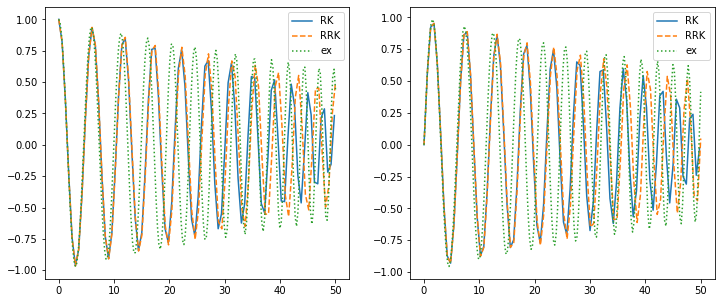

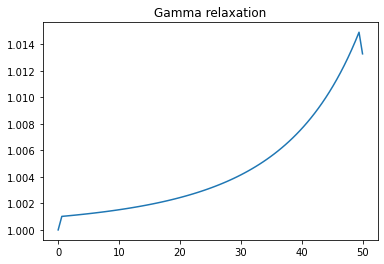

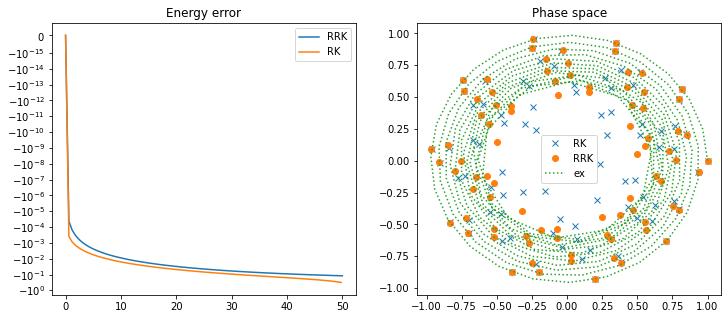

In [78]:
pr=ODEproblem("nonLinearOscillatorDamped")
dt0=1  #0.5
t_span=np.arange(0,pr.T_fin+10**-16,dt0)
rk44=rk.loadRKM('RK44')
tt,uu=explicitRK(pr.flux,t_span,pr.u0,rk44.A,rk44.b,rk44.c)
ttR,uuR, gammas = explicitRelaxRK(pr.flux, pr.u0, dt0, pr.T_fin, np.int(pr.T_fin//dt0*3),  rk44.A, rk44.b, rk44.c)

tEx=np.linspace(0,pr.T_fin, 200)
uEx=np.zeros((uu.shape[0], len(tEx)))
for k in range(len(tEx)):
    uEx[:,k] = pr.exact(pr.u0,tEx[k])

plt.figure(figsize=(12,5))
plt.subplot(121)
plt.plot(tt,uu[0,:],label="RK")
plt.plot(ttR,uuR[0,:],"--",label="RRK")
plt.plot(tEx,uEx[0,:],":",label="ex")

plt.legend()

plt.subplot(122)
plt.plot(tt,uu[1,:],label="RK")
plt.plot(ttR,uuR[1,:],"--",label="RRK")
plt.plot(tEx,uEx[1,:],":",label="ex")

plt.legend()

plt.figure()
plt.plot(ttR,gammas)
plt.title("Gamma relaxation")


plt.figure(figsize=(12,5))
plt.subplot(121)
errorEnRRK=[np.dot(uuR[:,k],uuR[:,k])-np.dot(pr.exact(pr.u0,ttR[k]),pr.exact(pr.u0,ttR[k])) for k in range(len(ttR))]
errorEnRK=[np.dot(uu[:,k],uu[:,k])-np.dot(pr.exact(pr.u0,tt[k]),pr.exact(pr.u0,tt[k])) for k in range(len(tt))]
plt.plot(ttR,errorEnRRK,label="RRK")
plt.plot(tt,errorEnRK,label="RK")
plt.title("Energy error")
plt.legend()
plt.yscale("symlog",linthreshy=1e-15)

plt.subplot(122)
plt.title("Phase space")
plt.plot(uu[0,:],uu[1,:], "x", label="RK")
plt.plot(uuR[0,:],uuR[1,:], "o", label="RRK")
plt.plot(uEx[0,:],uEx[1,:], ":", label="ex")
plt.legend()

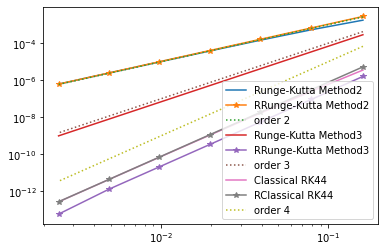

In [79]:
from nodepy import rk
## Convergence
pr=ODEproblem("nonLinearOscillator")
pr.T_fin=5
# Define some explicit RK
A=np.array([[0,0],[1/2,0]])
b=np.array([0,1])
rk2 = rk.ExplicitRungeKuttaMethod(A,b)

A=np.array([[0]])
b=np.array([1])
rk1 = rk.ExplicitRungeKuttaMethod(A,b)


A=np.array([[0,0,0],[2/3,0,0],[1/3,1/3,0]])
b=np.array([1/4,0,3/4])
rk3 = rk.ExplicitRungeKuttaMethod(A,b)

rk44=rk.loadRKM('RK44')



def error(tt,yy):
    errors=np.zeros(len(tt))
    for it, t in enumerate(tt):
        errors[it]=np.linalg.norm(yy[:,it]-pr.exact(yy[:,0],t))
    return np.mean(errors)

Ns=[2**k for k in range(5,10)]
solvers=[ rk2,rk3,rk44]  #rk1

errorEx  =np.zeros((len(solvers),len(Ns)))
errorRRK =np.zeros((len(solvers),len(Ns)))
dts=    np.zeros(len(Ns))



for iN, N in enumerate(Ns):
    tspan=np.linspace(0,pr.T_fin,N)
    dts[iN]=tspan[1]-tspan[0]
    for iS, rkM in enumerate(solvers):
        tt,yy=explicitRK(pr.flux,tspan,pr.u0,rkM.A,rkM.b,rkM.c)
        errorEx[iS,iN]=error(tt,yy)
        tt,yy, gammas =explicitRelaxRK(pr.flux,pr.u0,dts[iN], pr.T_fin, np.int(pr.T_fin//dts[iN]*3),\
                              rkM.A,rkM.b,rkM.c)
        errorRRK[iS,iN]=error(tt,yy)

plt.figure()
for iS, rkM in enumerate(solvers):
    orderRK=rkM.order()
    plt.loglog(dts,errorEx[iS,:],label=rkM.name+str(orderRK))
    plt.loglog(dts,errorRRK[iS,:],"*-",label="R"+rkM.name+str(orderRK))
    plt.loglog(dts,dts**(orderRK)/10,":", label="order %d"%(orderRK))
plt.legend()

You should see a superconvergence phenomenon for RRK with odd order. 

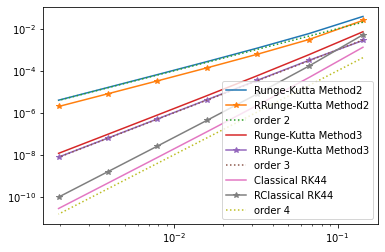

In [80]:
from nodepy import rk
## Convergence
pr=ODEproblem("linear_system2")
# Define some explicit RK
A=np.array([[0,0],[1/2,0]])
b=np.array([0,1])
rk2 = rk.ExplicitRungeKuttaMethod(A,b)

A=np.array([[0]])
b=np.array([1])
rk1 = rk.ExplicitRungeKuttaMethod(A,b)


A=np.array([[0,0,0],[2/3,0,0],[1/3,1/3,0]])
b=np.array([1/4,0,3/4])
rk3 = rk.ExplicitRungeKuttaMethod(A,b)

rk44=rk.loadRKM('RK44')



def error(tt,yy):
    errors=np.zeros(len(tt))
    for it, t in enumerate(tt):
        errors[it]=np.linalg.norm(yy[:,it]-pr.exact(yy[:,0],t))
    return np.mean(errors)

Ns=[2**k for k in range(3,10)]
solvers=[ rk2,rk3,rk44]  #rk1

errorEx  =np.zeros((len(solvers),len(Ns)))
errorRRK =np.zeros((len(solvers),len(Ns)))
dts=    np.zeros(len(Ns))



for iN, N in enumerate(Ns):
    tspan=np.linspace(0,pr.T_fin,N)
    dts[iN]=tspan[1]-tspan[0]
    for iS, rkM in enumerate(solvers):
        tt,yy=explicitRK(pr.flux,tspan,pr.u0,rkM.A,rkM.b,rkM.c)
        errorEx[iS,iN]=error(tt,yy)
        tt,yy, gammas =explicitRelaxRK(pr.flux,pr.u0,dts[iN], pr.T_fin, np.int(pr.T_fin//dts[iN]*5),\
                              rkM.A,rkM.b,rkM.c)
        errorRRK[iS,iN]=error(tt,yy)

plt.figure()
for iS, rkM in enumerate(solvers):
    orderRK=rkM.order()
    plt.loglog(dts,errorEx[iS,:],label=rkM.name+str(orderRK))
    plt.loglog(dts,errorRRK[iS,:],"*-",label="R"+rkM.name+str(orderRK))
    plt.loglog(dts,dts**(orderRK),":", label="order %d"%(orderRK))
plt.legend()

In this case, there is no energy to maintain, we recast the original error

## Pro exercise: code the relaxation RK for a general entropy
* $\frac{d}{dt} \eta(y(t)) \stackrel{(\leq)}{=}0 $ and $\langle \partial_u \eta (y), y \rangle \stackrel{(\leq)}{=}0 $
* The final equation can be a nonlinear equation in $\gamma$, hence a nonlinear solver must be used, try with scipy.optimize.newton or .broyden1
* The extra input we need are the entropy function $\eta(y)$ and the entropy variables function $\partial_y \eta(y)$
* Final relation that should hold is

$$
\eta(y^{n+1}_\gamma)-\eta(y^0)- \gamma \Delta t \sum_{j=1}^S b_j \langle \partial_y \eta(y^{(j)}), F(y^{(j)}) \rangle=0
$$

In [197]:
from scipy import optimize
## explicit RK method
def explicitRelaxRKEntropy(flux, entropy, e_v, y_0, dt0, T_fin, KtMax,  A, b, c):
    # Solving u'=F(u,t)
    # input: flux=F, tspan is a vector of times determining the RK steps
    # entropy: scalar function of y
    # entropy variable e_v: vector function of y
    # input: y_0 the initial condition
    # dt0 is the basic time interval, that will be modified along the steps
    # T_fin is the final time
    # KtMax is maximum number of timesteps
    # input: A,b,c are matrix and vectors of RK methods
    dim=len(y_0)          # S
    y=np.zeros((dim,KtMax))    # initializing the variable of solutions
    tspan=np.zeros(KtMax)      # times will be stored here
    gammas = np.zeros(KtMax)   # Gamma relaxation coefficients
    time= 0.
    gammas[0] = 1
    n=0                        # Time step index
    tspan[0] = time
    y[:,0]=y_0                 # first timestep 
    S=np.shape(A)[0]
    u=np.zeros((dim,S))       # Internal stages
    Fu=np.zeros((dim,S))       # Flux at internal stages
    while(time<T_fin and n<KtMax):    # n=0,..., N-1
        ent0=entropy(y[:,n])
        e_v0 = e_v(y[:,n])
        delta_t=min(dt0,T_fin-time)
        #Classic RK step
        for k in range(S):
            u[:,k]=y[:,n] 
            for j in range(k):
                u[:,k] = u[:,k]+ delta_t*A[k,j]*Fu[:,j]
            Fu[:,k] = flux(u[:,k],tspan[n]+delta_t*c[k])
        yn1=y[:,n]
        for j in range(S):
            yn1=yn1+delta_t*b[j]*Fu[:,j]
        # Compute the relaxation gamma
        deltay = yn1-y[:,n]
        sumBScal=0.
        for j in range(S):
            sumBScal=sumBScal + b[j]* np.dot(e_v(u[:,j]),Fu[:,j])
        residual = lambda gamma: np.array(entropy(np.array(y[:,n]+gamma*deltay,dtype=np.float))-ent0-gamma*delta_t*sumBScal, dtype=float)
        deriv_res = lambda gamma: np.array(np.dot(e_v(np.array(y[:,n]+gamma*deltay,dtype=np.float)),deltay)-delta_t*sumBScal, dtype=float)
        gamma = optimize.newton(residual,np.array([1.]),fprime=deriv_res,tol=10**-13) #broyden1(residual,1.,f_tol=10**-13)
        # Update the n+1 values
        y[:,n+1]=y[:,n] +gamma*deltay
        if (time+delta_t<T_fin -10**-16):
            time = time + gamma*delta_t
        else:
            time=T_fin
        tspan[n+1]=time
        gammas[n+1]=gamma
        n=n+1
        
    return tspan[:n+1], y[:,:n+1] , gammas[:n+1]

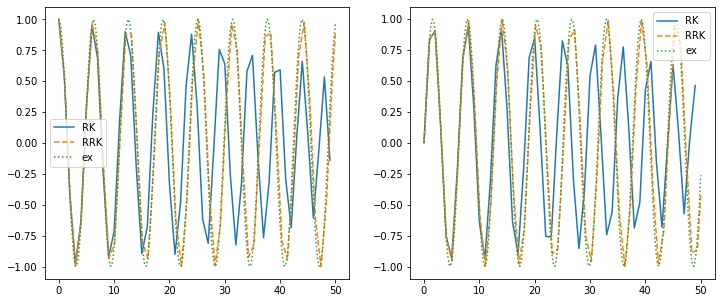

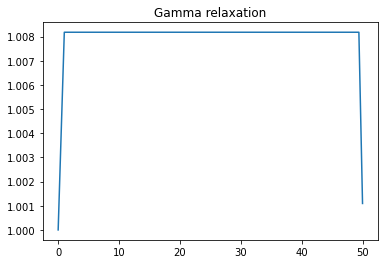

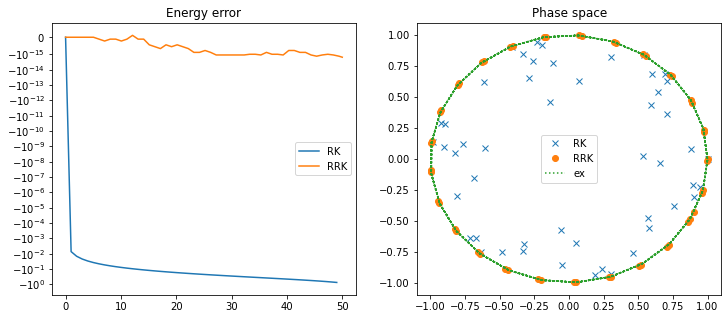

In [198]:
pr=ODEproblem("nonLinearOscillator")
dt0=1  #0.5
entropy = lambda y: (y[0]**2.+y[1]**2.)/2.  ##y[1]**2/2.-np.cos(y[0])
e_v= lambda y: y #np.array([ np.sin(y[0]), y[1] ])
t_span=np.arange(0,pr.T_fin+10**-16,dt0)
rk44=rk.loadRKM('RK44')
tt,uu=explicitRK(pr.flux,t_span,pr.u0,rk44.A,rk44.b,rk44.c)
ttR,uuR, gammas = explicitRelaxRKEntropy(pr.flux, entropy, e_v, pr.u0, dt0, pr.T_fin, np.int(pr.T_fin//dt0*5),  rk44.A, rk44.b, rk44.c)

tEx=np.linspace(0,pr.T_fin, 200)
uEx=np.zeros((uu.shape[0], len(tEx)))
for k in range(len(tEx)):
    uEx[:,k] = pr.exact(pr.u0,tEx[k])

plt.figure(figsize=(12,5))
plt.subplot(121)
plt.plot(tt,uu[0,:],label="RK")
plt.plot(ttR,uuR[0,:],"--",label="RRK")
plt.plot(tEx,uEx[0,:],":",label="ex")

plt.legend()

plt.subplot(122)
plt.plot(tt,uu[1,:],label="RK")
plt.plot(ttR,uuR[1,:],"--",label="RRK")
plt.plot(tEx,uEx[1,:],":",label="ex")

plt.legend()

plt.figure()
plt.plot(ttR,gammas)
plt.title("Gamma relaxation")


plt.figure(figsize=(12,5))
plt.subplot(121)
errorEnRRK=[np.dot(uuR[:,k],uuR[:,k])-np.dot(pr.exact(pr.u0,ttR[k]),pr.exact(pr.u0,ttR[k])) for k in range(len(ttR))]
errorEnRK=[np.dot(uu[:,k],uu[:,k])-np.dot(pr.exact(pr.u0,tt[k]),pr.exact(pr.u0,tt[k])) for k in range(len(tt))]
plt.plot(tt,errorEnRK,label="RK")
plt.plot(ttR,errorEnRRK,label="RRK")
plt.title("Energy error")
plt.legend()
plt.yscale("symlog",linthresh=1e-15)

plt.subplot(122)
plt.title("Phase space")
plt.plot(uu[0,:],uu[1,:], "x", label="RK")
plt.plot(uuR[0,:],uuR[1,:], "o", label="RRK")
plt.plot(uEx[0,:],uEx[1,:], ":", label="ex")
plt.legend()

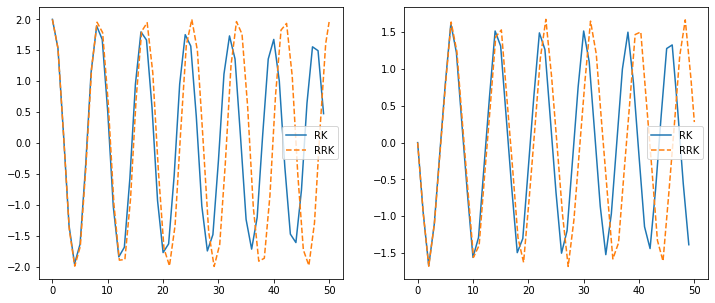

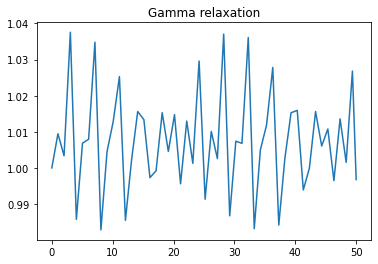

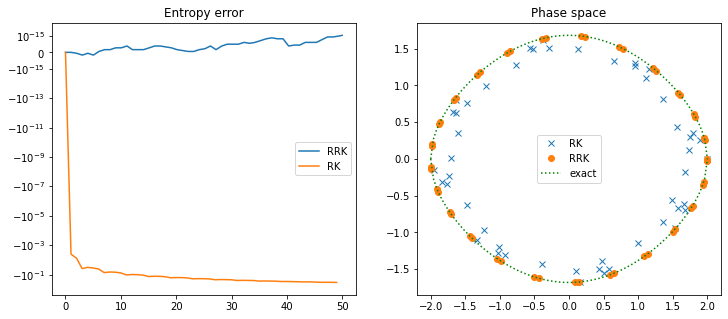

In [200]:
pr=ODEproblem("pendulum")
dt0=1  #0.5
entropy = pendulum_entropy
e_v= pendulum_entropy_variables
pr.u0=np.array([2.0,0.])
t_span=np.arange(0,pr.T_fin+10**-16,dt0)
rk44=rk.loadRKM('RK44')
tt,uu=explicitRK(pr.flux,t_span,pr.u0,rk44.A,rk44.b,rk44.c)
ttR,uuR, gammas = explicitRelaxRKEntropy(pr.flux, entropy, e_v, pr.u0, dt0, pr.T_fin, np.int(pr.T_fin//dt0*5),  rk44.A, rk44.b, rk44.c)

plt.figure(figsize=(12,5))
plt.subplot(121)
plt.plot(tt,uu[0,:],label="RK")
plt.plot(ttR,uuR[0,:],"--",label="RRK")

plt.legend()

plt.subplot(122)
plt.plot(tt,uu[1,:],label="RK")
plt.plot(ttR,uuR[1,:],"--",label="RRK")

plt.legend()

plt.figure()
plt.plot(ttR,gammas)
plt.title("Gamma relaxation")


plt.figure(figsize=(12,5))
plt.subplot(121)
errorEnRRK=[entropy(uuR[:,k])-entropy(uuR[:,0]) for k in range(len(ttR))]
errorEnRK=[entropy(uu[:,k])-entropy(uu[:,0]) for k in range(len(tt))]
plt.plot(ttR,errorEnRRK,label="RRK")
plt.plot(tt,errorEnRK,label="RK")
plt.title("Entropy error")
plt.legend()
plt.yscale("symlog",linthresh=1e-15)

plt.subplot(122)
uLin=np.linspace(-2,2,100)
plt.title("Phase space")
plt.plot(uu[0,:],uu[1,:], "x", label="RK")
plt.plot(uuR[0,:],uuR[1,:], "o", label="RRK")
plt.plot(uLin,np.sqrt(2.*np.cos(uLin)+2.*entropy(uu[:,0])),"g:",label="exact")
plt.plot(uLin,-np.sqrt(2.0*np.cos(uLin)+2.*entropy(uu[:,0])),"g:")
plt.plot()
plt.legend()